# Using Regressional Analysis to better understand the ADNI Database:

#### Read the database and select for each person the datapoint with their first MRI Scan:

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
print(unique.shape)
unique.head(10)

(1569, 207)


,PTID,Date,Age,Sex,DLICV,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,...,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,302.695176,352.265466,1062.069832,1159.101038,20657.100036,3254.764153,3118.709527,52564.546547,52086.773326,14018.899912,14294.173225,3600.701497,3368.670352,750.937160,587.460672,16514.289409,23626.044006,1544.061802,1339.452519,4182.888734,4105.896581,7365.934170,8007.183880,4747.146291,4789.333772,4638.513528,2017.616275,2812.850291,352.265466,380.742015,...,1,1,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,1
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,384.959763,340.663023,988.239172,1051.520229,18405.295394,3021.670466,3151.396633,45240.682248,43280.024169,12993.710346,13640.231811,3586.981241,3350.731962,475.662611,761.482051,16498.426213,13491.521327,1096.871653,1092.652915,2941.514461,3243.154165,6479.980225,6874.432146,4181.823176,4367.447609,3893.894367,1782.416435,2235.930676,503.084402,371.248867,...,2,2,1,1,1,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,512.577893,552.656000,1172.811970,1141.171359,23368.700372,3041.717375,3198.865741,49984.782089,49158.962150,17229.367210,17536.281134,4728.161925,4206.091848,764.648092,640.195023,16674.601836,16115.617714,1304.647848,1335.233771,4119.607512,4195.544978,7287.887330,7510.426292,5413.708490,5620.427146,3802.146719,1700.155481,2524.920733,563.202870,591.679420,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,2,0,0,0,0,1,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,280.547287,356.484899,876.446600,908.087272,21112.765397,2883.519862,2848.715123,56650.512928,55319.495347,13810.098417,14307.911649,3485.747309,3231.567248,1810.901098,1584.142953,47125.616120,60669.932896,1393.244235,1401.681747,3791.607134,3956.138626,7059.033810,7534.698571,5230.202998,5155.320075,4848.405562,2089.339007,3279.028256,557.930507,343.828630,...,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,2
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,278.437217,328.007479,910.194387,966.092767,19718.417441,3275.856043,3304.332576,48017.763654,46338.702862,15370.999989,15619.905986,3663.980648,3558.512005,850.077260,378.632427,19563.378537,20767.830436,1211.834705,1276.170577,3940.308492,3830.621103,6907.141411,7299.484762,4610.034373,4816.752913,4007.808423,1973.318305,3543.746395,275.273157,261.562234,...,0,1,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,1,2,2,0,0,0,0,0,2,0,0,2,1,1,1,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,356.484899,415.547486,761.485494,853.243441,18195.495486,3485.747309,2921.488668,44029.049070,42879.438005,11626.892084,12026.619234,2887.738618,2592.425684,392.344326,283.711354,8403.762348,9388.841921,1287.775330,1255.079969,3543.755207,3659.771003,6422.001624,6685.673886,3798.9899

In [66]:
unique.describe()

,Age,Sex,DLICV,APOE4_Alleles,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,MUSE_Volume_35,MUSE_Volume_36,MUSE_Volume_37,MUSE_Volume_38,MUSE_Volume_39,MUSE_Volume_40,MUSE_Volume_41,MUSE_Volume_47,MUSE_Volume_48,MUSE_Volume_49,MUSE_Volume_50,MUSE_Volume_51,MUSE_Volume_52,MUSE_Volume_55,MUSE_Volume_56,MUSE_Volume_57,MUSE_Volume_58,MUSE_Volume_59,MUSE_Volume_60,MUSE_Volume_61,MUSE_Volume_62,MUSE_Volume_71,MUSE_Volume_72,MUSE_Volume_73,MUSE_Volume_75,MUSE_Volume_76,MUSE_Volume_81,MUSE_Volume_82,MUSE_Volume_83,MUSE_Volume_84,...,rs2718058,rs4723711,rs1859788,rs1476679,rs12539172,rs10808026,rs7810606,rs11771145,rs28834970,rs73223431,rs4236673,rs9331896,rs11257238,rs7920721,rs3740688,rs10838725,rs983392,rs7933202,rs2081545,rs867611,rs10792832,rs3851179,rs17125924,rs17125944,rs10498633,rs12881735,rs12590654,rs442495,rs59735493,rs113260531,rs28394864,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358
count,1569.000000,1569.000000,1.569000e+03,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,...,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,73.815182,0.435946,1.428620e+06,0.572339,1760.674050,1748.219994,354.569893,390.793080,934.337007,982.747032,20201.859087,3175.843832,3074.570363,48491.662260,47531.161617,13477.348212,13758.918005,3558.240612,3262.752380,788.853004,747.360170,20081.819119,22260.115415,1357.134099,1375.812008,3947.413343,3986.362594,6941.167746,7131.639378,4461.922990,4633.328947,4207.688713,2122.035485,2863.044557,342.409322,316.200628,93511.041201,90993.609955,23702.673377,23755.190892,...,0.751434,0.713193,0.632250,0.555131,0.574888,0.364563,0.960484,0.684512,0.732951,0.735500,0.768642,0.776928,0.797323,0.824729,0.888464,0.644997,0.790312,0.758445,0.775653,0.609305,0.703633,0.703633,0.180370,0.181007,0.444232,0.449331,0.664755,0.648821,0.576801,0.264500,0.950287,0.342894,0.355003,0.360102,0.167623,0.590822,0.176546,0.182282,0.179095,0.569152
std,7.146120,0.496038,1.438380e+05,0.667217,777.345001,580.512029,65.275025,70.729248,162.612572,167.831276,2239.866070,490.436768,442.010175,5113.872524,5014.041732,1594.051062,1609.226654,557.123025,517.032506,657.770530,630.412652,10936.140392,12187.835568,167.604756,169.730734,513.676116,512.380243,695.892702,697.393505,467.710817,491.070174,574.852808,298.151993,412.213971,114.212730,117.339056,12332.092966,11932.604123,3409.505897,3616.231863,...,0.689322,0.677130,0.656992,0.639615,0.645555,0.550666,0.703286,0.679902,0.701268,0.704048,0.680925,0.680413,0.693238,0.695650,0.704161,0.647436,0.701680,0.693193,0.699412,0.646569,0.671575,0.671575,0.407171,0.407670,0.586503,0.588052,0.666079,0.674565,0.633360,0.486575,0.711657,0.533043,0.545893,0.550708,0.380416,0.642514,0.407281,0.411775,0.407733,0.666599
min,54.273973,0.000000,1.057343e+06,0.000000,279.599289,649.198349,188.787377,219.599442,428.399974,465.599972,14147.216048,1718.902409,1909.195145,33671.250000,32319.375000,8848.799473,9111.599457,1739.177918,1655.858626,34.799911,2.475464,2818.799832,3604.799785,913.199946,903.866268,2608.241008,2521.249264,4339.488159,4380.115207,3168.750000,3248.437500,2570.267046,1265.625

#### Performing Regressional Analysis to uncover the relation between age, sex and ROIs:

In [101]:
def RAplot(male_age_data, male_imaging_data, female_age_data, female_imaging_data, name_of_ROI):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(9,5), dpi=120);
    axes[0].title.set_text("Male Age vs ROI value " + name_of_ROI)
    axes[1].title.set_text("Female Age vs ROI value " + name_of_ROI)
    axes[0].set_xlabel("Age")
    axes[1].set_xlabel("Age")
    axes[0].set_ylabel(name_of_ROI)
    axes[1].set_ylabel(name_of_ROI)
    
    # Plot data and a linear regression model fit.     
    # order=n if change line shape     
    sns.regplot(x=male_age_data, y=male_imaging_data, 
                color = 'blue', 
                scatter=True, 
                marker="+",
                ax = axes[0])
    
    sns.regplot(x=female_age_data, y=female_imaging_data, 
                color = 'red', 
                scatter=True, 
                marker="x",
                ax = axes[1])

    plt.show()

In [96]:
male_CN_mask =      (unique['Sex'] == 0)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'CN')
female_CN_mask =    (unique['Sex'] == 1)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'CN')
male_MCI_mask =     (unique['Sex'] == 0)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'MCI')
female_MCI_mask =   (unique['Sex'] == 1)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'MCI')
male_AD_mask =      (unique['Sex'] == 0)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'Dementia')
female_AD_mask =    (unique['Sex'] == 1)   &   (unique['Age']>=70)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'Dementia')

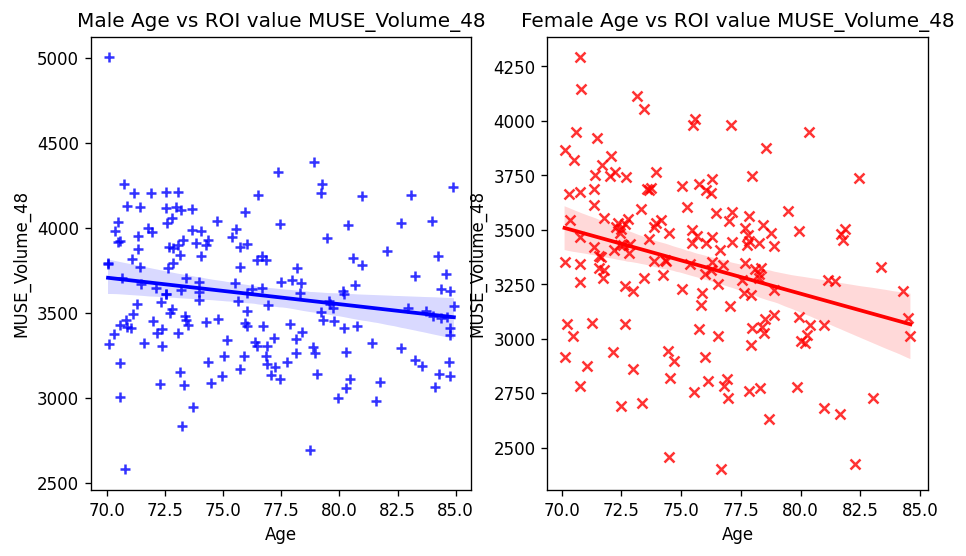

In [102]:
RAplot(unique[male_CN_mask].Age.tolist(),  unique[male_CN_mask].MUSE_Volume_48, 
     unique[female_CN_mask].Age.tolist(),unique[female_CN_mask].MUSE_Volume_48, 'MUSE_Volume_48')

Coefficients: 
 [[-15.59590074]]
Mean squared error: 394585.27
Coefficient of determination: -0.48


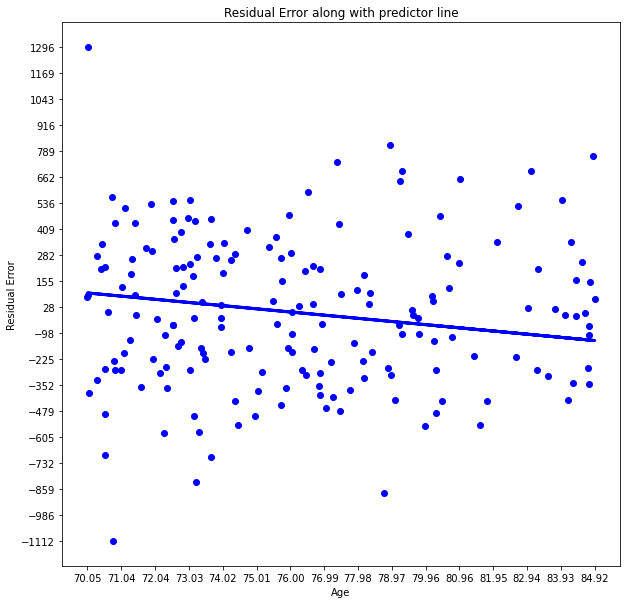

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = unique[['Age',]].values
Y = unique[['MUSE_Volume_48']].values

regr = LinearRegression().fit(X[male_CN_mask],Y[male_CN_mask])

Y_pred = Y.copy()
Y_pred = regr.predict(X)
Y_resid = Y - Y_pred

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y, Y_pred))

plt.scatter(X[male_CN_mask], Y_resid[male_CN_mask], color="blue")
plt.plot(X[male_CN_mask], Y_pred[male_CN_mask] - regr.intercept_ - (regr.coef_)*X[male_CN_mask].mean()  , color="blue", linewidth=3)

plt.xticks(np.linspace(min(X[male_CN_mask]), max(X[male_CN_mask]), num = 16))
plt.yticks(np.linspace(min(Y_resid[male_CN_mask]), max(Y_resid[male_CN_mask]), num = 20))

plt.title("Residual Error along with predictor line")
plt.xlabel('Age')
plt.ylabel('Residual Error')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()